# Lab 7: Regression

## Due Saturday, June 3rd at 11:59PM

Welcome to Lab 7, the final lab of the quarter! In this lab you will get some hands-on practice with linear regression, which is covered in [CIT 15](https://inferentialthinking.com/chapters/15/Prediction.html).

You should complete this entire lab so that all tests pass and submit it to Gradescope by 11:59PM on the due date.

<div class="alert alert-warning" markdown="block">
    
**Note**: The content relevant to this lab will be covered in Lectures 24 and 25, which are on Wednesday and Friday of this upcoming week. The lab is relatively self-explanatory, so you'll be able to make good progress before Wednesday's lecture.
    
However, if you'd like to get a head start and want a bit of extra guidance, you can take a look at the notebooks for Lectures 24 and 25 from the Fall 2022 offering of the course below:
- [Fall 2022 Lecture 24](https://dsc-courses.github.io/dsc10-2022-fa/resources/lectures/lec24/lec24.html)
- [Fall 2022 Lecture 25](https://dsc-courses.github.io/dsc10-2022-fa/resources/lectures/lec25/lec25.html)
    
This quarter's lectures will be similar, though not identical, to those linked above.
       
</div>

In [1]:
import numpy as np
import babypandas as bpd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

from IPython.display import YouTubeVideo

import otter
grader = otter.Notebook()

## 1. How faithful is Old Faithful?

(The clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

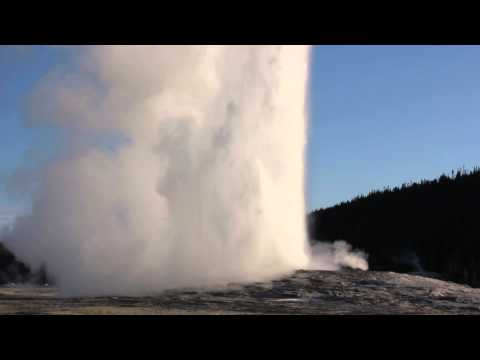

In [2]:
# Run this cell.
YouTubeVideo('wE8NDuzt8eg')

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to **predict when the next eruption will happen**, so you can see the rest of the park and come to see the geyser when it is erupting.  In this lab, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- `'duration'`: Eruption duration, in minutes.
- `'wait'`: Time between this eruption and the next, also in minutes.

Run the next cell to load the dataset.

In [3]:
faithful = bpd.read_csv('data/faithful.csv')
faithful

,duration,wait
0,3.600,79.0
1,1.800,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0
...,...,...
267,4.117,81.0
268,2.150,46.0
269,4.417,90.0
270,1.817,46.0


We would like to use linear regression to make predictions about waiting time given a duration, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

**Question 1.1.** Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the **vertical axis** and the other column on the horizontal axis.

<AxesSubplot:xlabel='duration', ylabel='wait'>

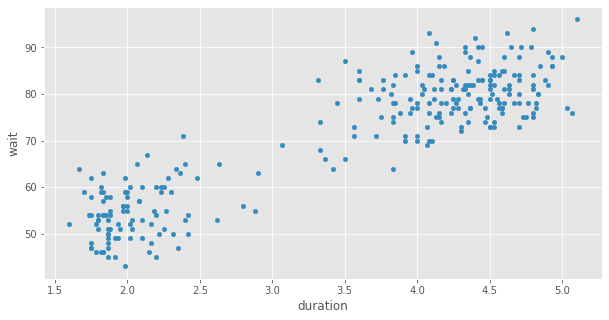

In [4]:
# Make your scatter plot.
faithful.plot(kind = 'scatter', x = 'duration', y = 'wait')

**Question 1.2.** Look at the scatter plot. Are the duration of the eruption and the waiting time roughly linearly related?  If so, is the relationship between them negative or positive?  Assign either 1, 2, or 3 to the variable `faith_q2` below. 
1. Eruption duration and waiting time are not roughly linearly related.
2. Eruption duration and waiting time are roughly linearly related. The relationship between them is negative.
3. Eruption duration and waiting time are roughly linearly related. The relationship between them is positive.

In [5]:
faith_q2 = 3

In [6]:
grader.check("q1_2")

q1_2 results: All test cases passed!

The scatterplot suggests that it is reasonable to use linear regression to analyze this data.

Next, we'd like to plot the data in standard units.  Recall that, if `nums` is a Series of numbers, then

```py
(nums - nums.mean()) / np.std(nums)
```

is a Series of those numbers in standard units.

**Question 1.3.** Compute the mean and standard deviation of the eruption durations and waiting times.  Then create a DataFrame called `faithful_su` containing the eruption durations and waiting times in **standard units**. The columns should be named `'duration_su'` and `'wait_su'`, respectively.

*Note*: You must use `np.std` to calculate the standard deviation.

In [7]:
# Use bpd.DataFrame() dont forget brackets to create a new dataframe

In [8]:
duration_mean = faithful.get('duration').mean()
duration_std = np.std(faithful.get('duration'))
wait_mean = faithful.get('wait').mean()
wait_std = np.std(faithful.get('wait'))

def standardize_dur(n):
    return ((n - duration_mean)/(duration_std))
def standardize_wait(n):
    return ((n - wait_mean)/(wait_std))

faithful_su = bpd.DataFrame().assign(duration_su = faithful.get('duration').apply(standardize_dur))
faithful_su = faithful_su.assign(wait_su = faithful.get('wait').apply(standardize_wait))
faithful_su

,duration_su,wait_su
0,0.098499,0.597123
1,-1.481459,-1.245181
2,-0.135861,0.228663
3,-1.057503,-0.655644
4,0.917443,1.039277
...,...,...
267,0.552298,0.744508
268,-1.174245,-1.834719
269,0.815624,1.407737
270,-1.466537,-1.834719


In [9]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4.** Create a scatter plot of the data again, but this time in standard units.

<AxesSubplot:xlabel='duration_su', ylabel='wait_su'>

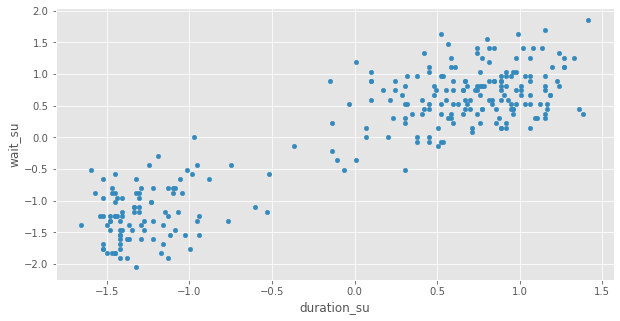

In [10]:
# Make your scatter plot.
faithful_su.plot(kind = "scatter", x = 'duration_su', y = "wait_su")

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the plots look the same because the axes are scaled differently.  The method `.plot` automatically scales the axes so the data fill up the available space.  This means it's important to read the ticks on the axes!

**Question 1.5.** Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset: `-1`, `0`, or `1`? Assign your answer to `correlation_guess`.

In [11]:
correlation_guess = 1

In [12]:
grader.check("q1_5")

q1_5 results: All test cases passed!

Now, you'll actually compute the correlation between duration and waiting time. To help you do so, we've defined a function `standard_units` that takes in an array or Series of numbers and returns a copy in which all values are in standard units:

In [13]:
def standard_units(any_numbers):
    '''Convert an array or Series of numbers to standard units.'''
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

**Question 1.6.** Complete the implementation of the function `correlation`, which takes in a DataFrame `df` and two column names `x` and `y` and returns the correlation between the two columns. Then, use your function to find the correlation between duration and waiting time, and assign it to the variable `r`. 

*Hints*:
- Does it matter if we compute the correlation between `'duration_su'` and `'wait_su'` or `'duration'` and `'wait'`?
- [CIT 15.1.2.](https://inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r) explains how to do this, if you're stuck.

In [14]:
# TO find correlation you get the product then the mean of the product

In [15]:
def correlation(df, x, y):
    return (standard_units(x)*standard_units(y)).mean()
r = correlation(faithful, faithful.get('duration'), faithful.get('wait'))
r

0.9008111683218132

In [16]:
grader.check("q1_6")

q1_6 results: All test cases passed!

## 2. The regression line

Recall that the correlation is the *slope* of the regression line when the data are put in standard units.

The next cell plots the **regression line in standard units**:

$$\text{wait_su} = r \times \text{duration_su}$$

Then, it overlays the line on a plot of the original data (in standard units) for comparison.  (You don't need to fully understand the code, **just run it**.)

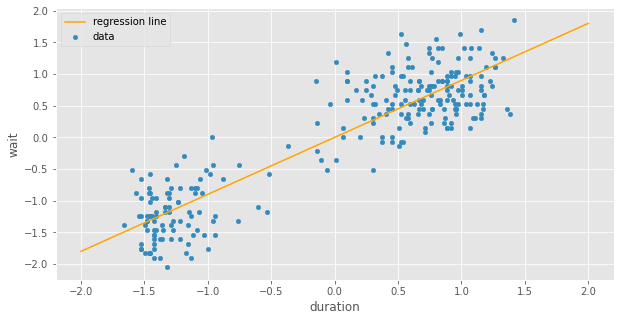

In [17]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    '''Makes a scatter plot of the dataset, along with a line passing through two points.'''
    dataset.plot(kind='scatter', x=x, y=y, label='data', figsize=(10, 5))
    xs, ys = zip(point_0, point_1)
    plt.plot(xs, ys, label='regression line', color='orange')
    plt.xlabel('duration')
    plt.ylabel('wait')
    plt.legend()

plot_data_and_line(faithful_su, 
                   'duration_su', 
                   'wait_su', 
                   [-2, -2 * r], 
                   [2, 2 * r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`.

That means the same thing would happen to the slope of the line.

Stretching a line **horizontally** makes it less steep, so we **divide the slope by a horizontal stretching factor**.  Stretching a line **vertically** makes it more steep, so we **multiply the slope by a vertical stretching factor**. (What value describes how spread out the durations are? What value describes how spread out the waiting times are?)

**Question 2.1.** What is the slope of the regression line in original units?

*Hint*: If the "stretching" explanation is unintuitive, consult [CIT 15.2.5](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line).

In [18]:
slope = r * (wait_std / duration_std)
slope

10.729641395133527

In [19]:
grader.check("q2_1")

q2_1 results: All test cases passed!

We know that the regression line passes through the point $(\verb|duration_mean|, \verb|wait_mean|)$.  So, now we know the slope of the regression line and a point that it passes through. You might recall the point-slope form of a line from high-school algebra. It says the equation for the line is:

$$\text{waiting time} - \verb|wait_mean| = \texttt{slope} \times (\text{eruption duration} - \verb|duration_mean|)$$

**Question 2.2.** Rearrange the above equation to find the intercept of the line. Then, assign `intercept` to be the intercept of the regression line.

*Hint*: Think of $\text{eruption duration}$ as $x$ and $\text{waiting time}$ as $y$. Try and rearrange the above equation to be in the form $y = mx + b$. $b$ is the intercept.

In [20]:
# y-y1 = m(x-x1)
# y = m(x)+m(x1+y1)
# -mx1+y1

intercept = (-slope * duration_mean)+wait_mean 
intercept

33.47439702275335

In [21]:
grader.check("q2_2")

q2_2 results: All test cases passed!

## 3. Investigating the regression line 
The slope and intercept tell you exactly what the regression line looks like.  

$$\text{waiting time} = \texttt{slope} \times (\text{eruption duration}) + \texttt{intercept}$$

In [22]:
slope

10.729641395133527

In [23]:
intercept

33.47439702275335

To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

**Question 3.1.** Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.

In [24]:
two_minute_predicted_waiting_time = slope * 2 + intercept
five_minute_predicted_waiting_time = slope * 5 + intercept

# Here is a helper function to print out your predictions.
# Please don't modify it.
def print_prediction(duration, predicted_waiting_time):
    print('After an eruption lasting', duration,
          'minutes, we predict you\'ll wait', predicted_waiting_time,
          'minutes until the next eruption.')

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813020404 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.12260399842098 minutes until the next eruption.


In [25]:
grader.check("q3_1")

q3_1 results: All test cases passed!

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

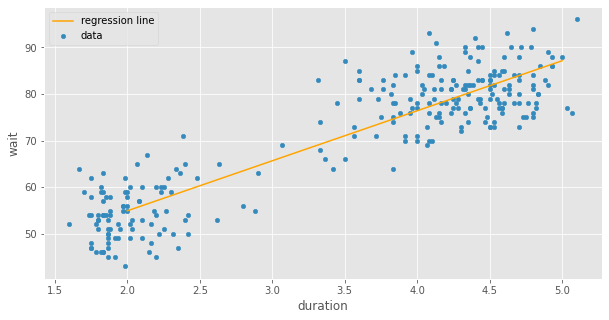

In [26]:
plot_data_and_line(faithful, 'duration', 'wait', 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

**Question 3.2.** Make predictions for the waiting time after **each** eruption in the `faithful` DataFrame. Put these numbers into a column in a new DataFrame called `faithful_predictions`. Its first row should look like this:

||duration|wait|predicted_wait|
|-|-|-|-|
|**0**|3.600|79.0|72.101106|

Note that we know exactly what the true waiting times were for every eruption in our dataset!  We are doing this so we can see how accurate our predictions are.

*Hint*: There is no need for a `for`-loop or even `.apply`; use Series arithmetic instead.

In [27]:
faithful_predictions = faithful.assign(predicted_wait = (slope * faithful.get("duration") + intercept))
faithful_predictions

,duration,wait,predicted_wait
0,3.600,79.0,72.101106
1,1.800,54.0,52.787752
2,3.333,74.0,69.236292
3,2.283,62.0,57.970168
4,4.533,85.0,82.111861
...,...,...,...
267,4.117,81.0,77.648331
268,2.150,46.0,56.543126
269,4.417,90.0,80.867223
270,1.817,46.0,52.970155


In [28]:
grader.check("q3_2")

q3_2 results: All test cases passed!

**Question 3.3.** How good are our predictions? To answer this question, we can compute the **residual** for each prediction. Residuals are defined as follows (note that there is no absolute value):

$$\text{residual} = \text{actual wait} - \text{predicted wait}$$

Compute the residual for each eruption in the dataset. Add the residuals to `faithful_predictions` as a new column called `'residual'`, naming the resulting DataFrame `faithful_residuals`.

*Hint*: Again, there is no need for a `for`-loop or `.apply`.

In [29]:
faithful_residuals = faithful_predictions.assign(residual = (faithful_predictions.get("wait")-faithful_predictions.get("predicted_wait")))
faithful_residuals

,duration,wait,predicted_wait,residual
0,3.600,79.0,72.101106,6.898894
1,1.800,54.0,52.787752,1.212248
2,3.333,74.0,69.236292,4.763708
3,2.283,62.0,57.970168,4.029832
4,4.533,85.0,82.111861,2.888139
...,...,...,...,...
267,4.117,81.0,77.648331,3.351669
268,2.150,46.0,56.543126,-10.543126
269,4.417,90.0,80.867223,9.132777
270,1.817,46.0,52.970155,-6.970155


In [30]:
grader.check("q3_3")

q3_3 results: All test cases passed!

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

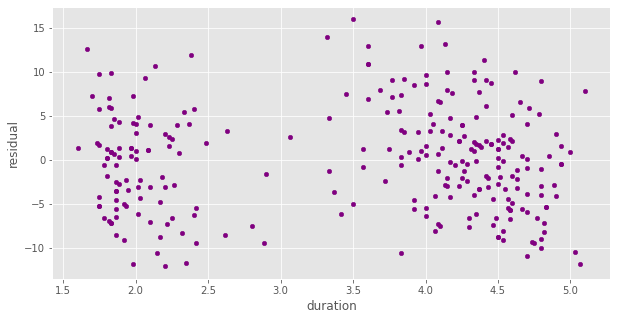

In [31]:
faithful_residuals.plot(kind='scatter', x='duration', y='residual', color='purple', figsize=(10, 5));

If a linear fit is good, the residual plot should look like a patternless "blob". This implies that the accuracy of the line's predictions is roughly the same for all durations. (This is an idea you will study further in future courses; see [CIT 15.5.](https://inferentialthinking.com/chapters/15/5/Visual_Diagnostics.html) for more details).

In the residual plot above, there isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations themselves, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so a line fits the data fairly well.  This means that, overall, the residuals are small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

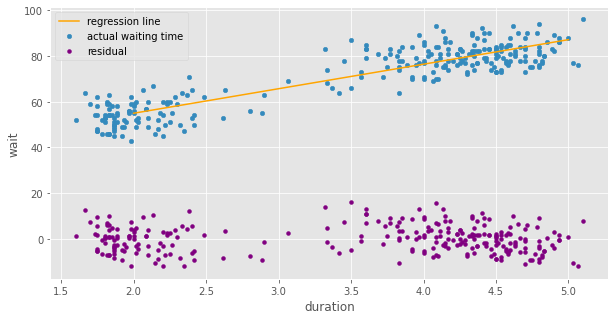

In [32]:
faithful_residuals.plot(kind='scatter', x='duration', y='wait', label='actual waiting time', figsize=(10, 5));
plt.scatter(faithful_residuals.get('duration'), faithful_residuals.get('residual'), label='residual', color='purple', s=15)
plt.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label='regression line', color='orange')
plt.legend();

However, even though the regression line fits the data well, you should be wary of applying your prediction model to data that are very different from the data in your sample.

**Question 4.1.** In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  60 minutes (an hour)?

In [33]:
zero_minute_predicted_waiting_time = slope * 0 + intercept
two_point_five_minute_predicted_waiting_time = slope * 2.5 + intercept
hour_predicted_waiting_time = slope * 60 + intercept

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.47439702275335 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.29850051058717 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880730765 minutes until the next eruption.


In [34]:
grader.check("q4_1")

q4_1 results: All test cases passed!

**Question 4.2.** Do you believe any of these values are reliable predictions?  Why or why not? Assign `true_predictions` to a list of the correct statements.
1. The predicted waiting time for a zero minute duration is reliable.
2. The predicted waiting time for a 2.5 minute duration is reliable.
3. The predicted waiting time for an hour duration is reliable.
4. We have data for all of the durations we predicted waiting times for.
5. We have data surrounding (above and below) all of the durations we predicted waiting times for.

*Hint*: What does a duration of zero minutes mean?

In [35]:
true_predictions = [2]

In [36]:
grader.check("q4_2")

q4_2 results: All test cases passed!

## 5. Divide and conquer

It appears from the scatter plot that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

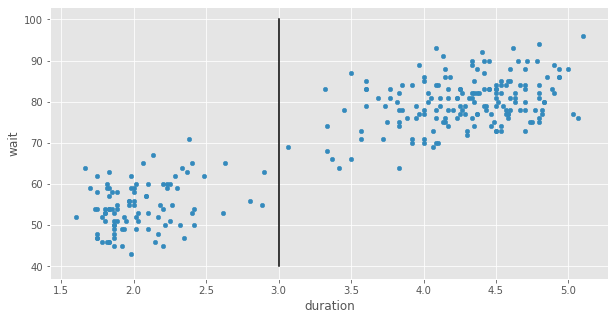

In [37]:
faithful_residuals.plot(kind='scatter', x='duration', y='wait', figsize=(10, 5));
plt.plot([3, 3], [40, 100], color='black');

The `standardize` function below returns a DataFrame with all columns converted to standard units. It uses the `standard_units` function we defined for you right before Question 1.6. Pay attention to the names of the columns in the DataFrame that `standardize` returns.

In [38]:
def standardize(df):
    '''Return a DataFrame in which all columns of df are converted to standard units.'''
    df_su = bpd.DataFrame().assign(duration_su=standard_units(df.get('duration')),
                                   wait_su=standard_units(df.get('wait')))
    return df_su

**Question 5.1.** Assign `below_3_r` to the correlation coefficient of all points with a duration below 3 and `above_3_r` to the correlation coefficient of all points with a duration above or equal to 3. To do so:
1. Create two DataFrames, `below_3` and `above_3`. `below_3` should contain all rows in `faithful` in which the duration is below 3, and `above_3` should contain all rows in `faithful` in which the duration is above or equal to 3.
2. Call your `correlation` function from Question 1.6 on both `below_3` and `above_3`.

In [47]:
below_3 = faithful[faithful.get("duration")<3]
above_3 = faithful[faithful.get("duration")>=3]

below_3_r = correlation(below_3, below_3.get("duration"), below_3.get("wait"))
above_3_r = correlation(above_3, above_3.get("duration"), above_3.get("wait"))
print(f'For points below 3, r is {below_3_r}. \nFor points above 3, r is {above_3_r}.')

For points below 3, r is 0.2901895264925431. 
For points above 3, r is 0.3727822255707511.


In [48]:
grader.check("q5_1")

q5_1 results: All test cases passed!

**Question 5.2.** Below, complete the implementation of the functions `slope_of` and `intercept_of`. Both functions should take in a DataFrame `df` that contains a `'duration'` column and a `'wait'` column (both of which are in **original units**, not standard units).

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration **below** 3. The second function should use the regression line for all points with duration **above or equal to** 3.

In [67]:
# def correlation(df, x, y):
#     return (standard_units(x)*standard_units(y)).mean()
# r = correlation(faithful, faithful.get('duration'), faithful.get('wait'))
# r

# slope = r * (wait_std / duration_std)
# slope

# duration_mean = faithful.get('duration').mean()
# duration_std = np.std(faithful.get('duration'))
# wait_mean = faithful.get('wait').mean()
# wait_std = np.std(faithful.get('wait'))


In [68]:
# # y-y1 = m(x-x1)
# # y = m(x)+m(x1+y1)
# # -mx1+y1

# intercept = (-slope * duration_mean)+wait_mean 
# intercept



In [77]:
#do intercept separately and dont have too many brackets

In [78]:
def slope_of(df):
    '''Return the slope of the regression line for the given DataFrame in original units.    
    Assume that the `duration` column contains x values and the `wait` column contains y values.
    '''
    r = correlation(df, df.get("duration"), df.get('wait'))
    return (r*((np.std(df.get('wait')))/(np.std(df.get('duration')))))

def intercept_of(df):
    '''Return the intercept of the regression line for the given DataFrame in original units.
    Assume that the `duration` column contains x values and the `wait` column contains y values.
    '''
    return df.get('wait').mean() -slope_of(df) * df.get('duration').mean()
    #return df.get('wait').mean() - slope_of(df) * df.get('duration').mean()
    
below_3_a = slope_of(below_3)
below_3_b = intercept_of(below_3)
above_3_a = slope_of(above_3)
above_3_b = intercept_of(above_3)

def wait_below_3(duration):
    return below_3_a * duration + below_3_b

def wait_above_3(duration):
    return above_3_a * duration + above_3_b

In [70]:
grader.check("q5_2")

q5_2 results: All test cases passed!

The plot below shows two different regression lines, one for each cluster!

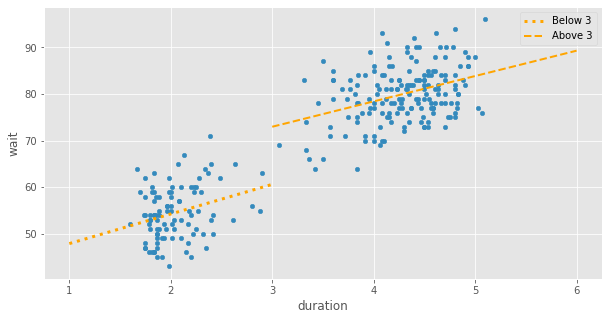

In [71]:
faithful_residuals.plot(kind='scatter', x='duration', y='wait', figsize=(10, 5))
plt.plot([1, 3], [wait_below_3(1), wait_below_3(3)], ':', color='orange', label='Below 3', linewidth=3)
plt.plot([3, 6], [wait_above_3(3), wait_above_3(6)], '--', color='orange', label='Above 3', linewidth=2)
plt.legend();

**Question 5.3.** Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than or equal to 3.

In [79]:
def predict_wait(duration):
    '''Return the wait predicted by the appropriate one of the two regression lines above.'''
    if duration<3:
        return wait_below_3(duration)
    else:
        return wait_above_3(duration)

In [80]:
grader.check("q5_3")

q5_3 results: All test cases passed!

The predicted wait times for each point appear below.

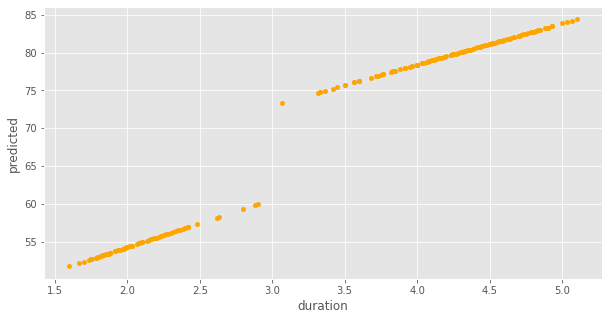

In [81]:
new_faithful = faithful.assign(predicted = faithful.get('duration').apply(predict_wait))
new_faithful.plot(kind='scatter', x='duration', y='predicted', color='orange', figsize=(10, 5));

**Question 5.4.** Do you think the predictions produced by `predict_wait` are more or less accurate than the predictions from the original regression line you created in Question 2? How can you tell? To answer this question, let's create another plot of the residuals, this time from `new_faithful`, and see if they're any different than before.  

Add a column called `new_residuals` to the `new_faithful` DataFrame. This column should contain the residuals from the predictions made by `predict_wait`. Then, create a residual plot to show, for each eruption, how much the new prediction over- or under-estimates the actual wait time.

In [85]:
new_faithful = faithful.assign(predicted = faithful.get('duration').apply(predict_wait))
new_faithful

,duration,wait,predicted
0,3.600,79.0,76.228703
1,1.800,54.0,52.982570
2,3.333,74.0,74.776539
3,2.283,62.0,56.049872
4,4.533,85.0,81.303117
...,...,...,...
267,4.117,81.0,79.040570
268,2.150,46.0,55.205253
269,4.417,90.0,80.672215
270,1.817,46.0,53.090529


<AxesSubplot:xlabel='new_residuals', ylabel='wait'>

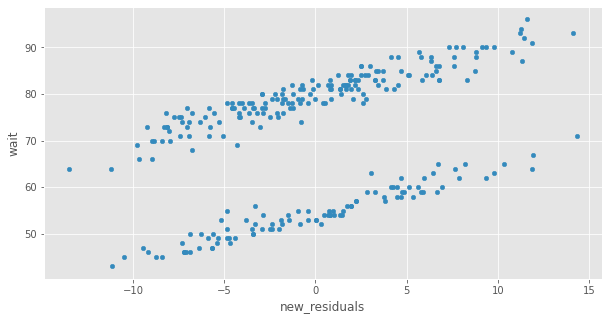

In [102]:
new_faithful = faithful.assign(new_residuals = new_faithful.get('wait') - 
                               new_faithful.get('duration').apply(predict_wait))

new_faithful
# Create your residual plot here.
new_faithful.plot(kind = "scatter", x = 'new_residuals', y = 'wait')

For comparison's sake, here is the residual plot we created with our old predictions in Question 3.

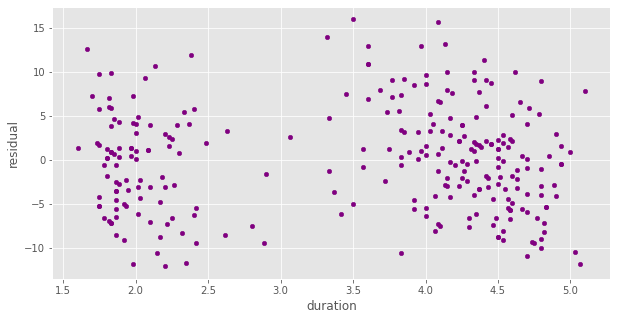

In [94]:
faithful_residuals.plot(kind='scatter', x='duration', y='residual', color='purple', figsize=(10, 5));

**Question 5.5.** Now that we have plotted the residuals, can we say that the new set of predictions are more or less accurate than before?  Assign either 1, 2, 3, or 4 to the variable `new_predict` below.
1. The new predictions are more accurate than the old predictions because the new residuals have a lower max value than the old residuals, as well as a lower minimum value than the old residuals, so the new predictions are closer to the true values than the old predictions.
2. The new predictions are more accurate than the old predictions because the new residuals exhibit less spread than the old residuals, so the new predictions are closer to the true values more often than the old predictions.
3. The new predictions are less accurate than the old predictions because they can't predict what will happen after a three minute duration.
4. We cannot tell if the new predictions are more accurate than the old predictions because the new and old residuals look similar.

In [103]:
new_predict = 4

In [104]:
grader.check("q5_5")

q5_5 results: All test cases passed!

## Finish Line 🏁

Congratulations! You've finished the last lab of the quarter!

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.
5. Stick around while the Gradescope autograder grades your work. Make sure you see that all tests have passed on Gradescope.
6. Check that you have a confirmation email from Gradescope and save it as proof of your submission.

In [105]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q1_2 results: All test cases passed!

q1_3 results: All test cases passed!

q1_5 results: All test cases passed!

q1_6 results: All test cases passed!

q2_1 results: All test cases passed!

q2_2 results: All test cases passed!

q3_1 results: All test cases passed!

q3_2 results: All test cases passed!

q3_3 results: All test cases passed!

q4_1 results: All test cases passed!

q4_2 results: All test cases passed!

q5_1 results: All test cases passed!

q5_2 results: All test cases passed!

q5_3 results: All test cases passed!

q5_5 results: All test cases passed!